In [252]:
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import wordpunct_tokenize
import zipfile
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import math
import statistics

from networkx.readwrite import json_graph
import json

from abc import ABC, abstractmethod

In [418]:
class QuestTextDataset:
    def __init__(self, quest_paths, target_positive_proportion = 0.5, stop_looking_for_negative_coef = 3, random_seed=42):
        random.seed = random_seed
        self.quest_paths = quest_paths
        self.data = []
        self.stop_looking_for_negative_coef = stop_looking_for_negative_coef
        self.adding_negative_coef = (1-target_positive_proportion)/target_positive_proportion
        for graph_path in tqdm(self.quest_paths):
            G = self.read_graph(graph_path)
            self.data += self.process_quest_graph(G)
        self.data.sort(key = lambda x: max(len(x[0][0].split()), len(x[0][1].split())))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        pair, category = self.data[i]
        fragment1, fragment2 = pair
        return fragment1, fragment2, category
        
            
    def read_graph(self, graph_path):
        return json_graph.node_link_graph(json.load(open(graph_path, encoding='utf-8')))
        
    def process_quest_graph(self, G):
        edges = G.edges()
        nodes = G.nodes()
        nodes_with_text = [node for node in nodes if 'fragment_text' in nodes[node] and isinstance(nodes[node]['fragment_text'], str) and nodes[node]['fragment_text'].strip()]
        positive_samples = [[(nodes[node_from]['fragment_text'], nodes[node_to]['fragment_text']), 1] for node_to, node_from in G.edges() if node_to in nodes_with_text and node_from in nodes_with_text] 
    
        target_num_negatives = round(len(positive_samples) * self.adding_negative_coef)
        max_tries = target_num_negatives * self.stop_looking_for_negative_coef
        negative_pairs = []
        for i in range(max_tries):
            negative_candidates = tuple(random.choices(nodes_with_text, k=2))
            if not G.has_edge(*negative_candidates) and negative_candidates not in negative_pairs:
                negative_pairs.append(negative_candidates)
            if len(negative_pairs) >= target_num_negatives:
                break
        negative_samples = [[(nodes[node_from]['fragment_text'], nodes[node_to]['fragment_text']), 0] for node_from, node_to in negative_pairs]
        all_samples = positive_samples + negative_samples
        random.shuffle(positive_samples+negative_samples)
        return all_samples
            

In [410]:
class MaskedMeanFragmentVectorizer(torch.nn.Module):
    def __init__(self, input_size, pad=0):
        super().__init__()
        self.pad = pad
        self.output_size=input_size
        
    def forward(self, batch:torch.Tensor):
        vector_dim = batch.shape[2]
        output = torch.zeros(batch.shape[0], vector_dim)
        for i, sample in enumerate(batch):
            real_vectors_counter = 0
            for vector in sample:
                if not sum(vector)==0 or any(vector):
                    real_vectors_counter += 1
            if real_vectors_counter:
                output[i] = torch.sum(sample, 0)/real_vectors_counter
        return output

In [345]:
class LSTMBasedFragmentVectorizer(torch.nn.Module):
    def __init__(self, input_size, hidden_size=50):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.input_size = input_size
        self.output_size = 4*hidden_size
        
    def forward(self, batch:torch.Tensor):
        states1, states2 = self.lstm(batch)[1]
        return torch.cat((states1[0], states1[1], states2[0], states2[0]), 1)

In [364]:
class CNNBasedFragmentVectorizer(torch.nn.Module):
    def __init__(self, input_size, num_bigram_filters=25, num_trigram_filters=25):
        super().__init__()
        self.output_size = num_bigram_filters + num_trigram_filters
        self.conv_2 = torch.nn.Conv1d(in_channels=input_size, out_channels=num_bigram_filters, kernel_size=2)
        self.conv_3 = torch.nn.Conv1d(in_channels=input_size, out_channels=num_trigram_filters, kernel_size=3)
        
    def forward(self, batch):
        batch_size = batch.shape[1]
        pooling_2 = torch.nn.MaxPool1d(kernel_size=batch_size-1)
        pooling_3 = torch.nn.MaxPool1d(kernel_size=batch_size-2)
        
        transposed_batch = torch.transpose(batch, 1, 2)
        birgam_result = pooling_2(self.conv_2(transposed_batch))
        trigam_result = pooling_3(self.conv_3(transposed_batch))
        return torch.squeeze(torch.cat((birgam_result, trigam_result), 1))

# Pretrained Russian word2vec embeddings

In [97]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words 
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [98]:
vocab_w2v_100000, embeddings_w2v_100000 = load_embeddings('D:\\ML_HSE\\wiki-news-300d-1M.vec — копия.zip', 'wiki-news-300d-1M.vec')

100%|████████████████████████████████████████████████████████████████████████▉| 99999/100000 [00:20<00:00, 4819.48it/s]


In [257]:
embeddings_w2v_100000 = torch.tensor(embeddings_w2v_100000).float()

<ipython-input-257-1104d4f1ed6c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_w2v_100000 = torch.tensor(embeddings_w2v_100000).float()


In [302]:
class QuestFragmentsPairsBatchEmbedder(ABC):
    def __init__(self, pad_id=0, **kwargs):
        self.pad_id = pad_id
    
    @abstractmethod
    def embed_tokens(self, tokens:torch.tensor):
        pass
    
    def embed_batch(self, tokenized_texts, max_len):
        padded_tokenized_texts = [self.pad_sequence(tokenized_text, max_len) for tokenized_text in tokenized_texts]
        tokens_tensor = torch.tensor(padded_tokenized_texts)
        embedded_tokens = self.embed_tokens(tokens_tensor)
        return embedded_tokens
        
    def pad_sequence(self, sequence:list, max_len:int):
        sequence_beginning = sequence[:max_len]
        pads = [self.pad_id for i in range(max_len-len(sequence_beginning))]
        return pads + sequence_beginning
    
    def __call__(self, texts1:list, texts2:list):
        assert len(texts1) == len(texts2)
        tokenized_texts1 = [self.encode(text) for text in texts1]
        tokenized_texts2 = [self.encode(text) for text in texts2]
        max_len = self.calc_max_len(tokenized_texts1, tokenized_texts2)
        embeddings1 = self.embed_batch(tokenized_texts1, max_len)
        embeddings2 = self.embed_batch(tokenized_texts2, max_len)
        return embeddings1, embeddings2
                
    def calc_max_len(self, tokenized_fragments1, tokenized_fragments2):
        return max([len(tokenized_fragment) for tokenized_fragment in tokenized_fragments1 + tokenized_fragments2])
   
    @abstractmethod
    def encode(self, text):
        pass   

In [304]:
class QuestFragmentPairwiseWord2VecEmbedder(QuestFragmentsPairsBatchEmbedder):
    def __init__(self, vocab:dict, embeddings:torch.tensor, padding_idx=0):
        super().__init__()
        assert len(vocab) == embeddings.shape[0]
        self.vocab = vocab
        self.embedding_layer = torch.nn.Embedding.from_pretrained(embeddings, padding_idx)
        
    def embed_tokens(self, tokens:torch.tensor):
        return self.embedding_layer(tokens)
    
    def encode(self, text):
        return [self.vocab[token] for token in wordpunct_tokenize(text) if token in self.vocab]
        

# Full pipeline

In [458]:
class PairsClassifier(torch.nn.Module):
    def __init__(self, encoder_type, input_size, CNN_num_bigram_filters=25, CNN_num_trigram_filters=25, LSTM_hidden_size=50):
        super().__init__()
        if encoder_type == 'BOW':
            self.encoder = MaskedMeanFragmentVectorizer(input_size)
        elif encoder_type == 'LSTM':
            self.encoder = LSTMBasedFragmentVectorizer(input_size, LSTM_hidden_size)
        elif encoder_type ==  'CNN':
            self.encoder = CNNBasedFragmentVectorizer(input_size, CNN_num_bigram_filters, CNN_num_trigram_filters)
       
        else:
            error_message = "encoder_type should be in ['BOW', 'CNN', 'LSTM'], not " + encoder_type
            raise ValueError(error_message)
        text_embedding_dim = self.encoder.output_size
        self.linear = torch.nn.Linear(in_features=2*text_embedding_dim, out_features=1)
        self.non_linear = torch.nn.Sigmoid()
    
    def forward(self, embeddings1, embeddings2):
        text_embeddings1 = self.encoder(embeddings1)
        text_embeddings2 = self.encoder(embeddings2)
        pair_embedding = torch.cat((text_embeddings1, text_embeddings2), 1)
        prediction = self.linear(pair_embedding)
        prediction = self.non_linear(prediction)
        return prediction

In [432]:
BOOK_GRAPHS_DIRECTORY = 'D:\Диплом_текстовые_квесты\Data\questbook_graphs'
ONLINE_GRAPHS_DIRECTORY = 'D:\Диплом_текстовые_квесты\Data\questbook_online_joined_texts'

dev_online_graphs, test_online_graphs = train_test_split(os.listdir(ONLINE_GRAPHS_DIRECTORY), random_state=42, test_size=0.4)

all_dev_graphs = [os.path.join(BOOK_GRAPHS_DIRECTORY, book_graph) for book_graph in os.listdir(BOOK_GRAPHS_DIRECTORY)] + [os.path.join(ONLINE_GRAPHS_DIRECTORY, online_graph) for online_graph in dev_online_graphs]
test_graphs_paths = [os.path.join(ONLINE_GRAPHS_DIRECTORY, test_graph) for test_graph in test_online_graphs]

train_paths, valid_paths = train_test_split(all_dev_graphs, random_state=42, test_size=0.1)

In [247]:
batch_size=30

In [419]:
train_dataset = QuestTextDataset(train_paths)
valid_dataset = QuestTextDataset(valid_paths)



  0%|                                                                                          | 0/249 [00:00<?, ?it/s]

  2%|█▎                                                                                | 4/249 [00:00<00:11, 20.54it/s]

  4%|███▎                                                                             | 10/249 [00:00<00:09, 25.33it/s]

  5%|████▏                                                                            | 13/249 [00:00<00:10, 23.14it/s]

  8%|██████▏                                                                          | 19/249 [00:00<00:08, 26.91it/s]

  9%|███████▍                                                                         | 23/249 [00:00<00:07, 28.73it/s]

 12%|█████████▊                                                                       | 30/249 [00:00<00:06, 32.55it/s]

 14%|███████████▋                                                                     | 36/249 [00:01<00:06, 30.53it/s]

 16%|█████████████▎           

In [420]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [249]:
len(train_dataset)

152794

In [250]:
len(valid_dataset)

21380

In [444]:
class PairClassificationTrainingOrganizer:
    def __init__(self, model, best_state_dict_path):
        self.model = model
        self.optimizer =  torch.optim.Adam([{'params': self.model.parameters()}], 
                               lr = 1e-3)
        self.criterion = torch.nn.BCELoss()
        self.best_state_dict_path = best_state_dict_path
        self.valid_epoch_losses = []
        self.best_valid_epoch_loss = math.inf
        self.current_epoch_valid_losses = []
        
    
    def set_train_mode(self):
        self.model.train()
        
    def set_valid_mode(self):
        self.model.eval()
        self.current_epoch_valid_losses = []
    
    def training_step(self, embeddings1, embeddings2, targets):
        prediction = self.model(embeddings1, embeddings2)
        loss = criterion(prediction.float(), targets.float())
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def validation_step(self, embeddings1, embeddings2, targets):
        prediction = self.model(embeddings1, embeddings2)
        loss = criterion(torch.softmax(prediction, 1).float(), targets.float())
        self.current_epoch_valid_losses.append(float(loss))
    
    def checkpoint(self):
        if self.current_epoch_valid_losses:
            current_epoch_mean_valid_loss = statistics.mean(self.current_epoch_valid_losses)
            self.valid_epoch_losses.append(current_epoch_mean_valid_loss)
            if current_epoch_mean_valid_loss < self.best_valid_epoch_loss:
                self.best_valid_epoch_loss = current_epoch_mean_valid_loss
                torch.save(self.model.state_dict(), self.best_state_dict_path)    

In [305]:
embedder = QuestFragmentPairwiseWord2VecEmbedder(vocab_w2v_100000, embeddings_w2v_100000)
input_size = 300

In [259]:
PAIRWISE_MODELS_DIR = 'D:\Диплом_текстовые_квесты\Pairwise models'
W2V_DIR = 'Standart word2wec'

In [460]:
training_organizers = []

for encoder_type in ['BOW', 'LSTM', 'CNN']:
    classifier = PairsClassifier(encoder_type, input_size)
    best_state_dict_path = os.path.join(PAIRWISE_MODELS_DIR, enoder_type, W2V_DIR, '100000_embeddings_model.pth')
    training_organizer = PairClassificationTrainingOrganizer(classifier, best_state_dict_path)
    training_organizers.append(training_organizer)

In [461]:
epochs = 1
for epoch in range(epochs):
    for training_organizer in training_organizers:
        training_organizer.set_train_mode()
    for fragments1, fragments2, are_neighbours in tqdm(train_dataloader):
        embeddings1, embeddings2 = embedder(fragments1, fragments2)
        targets = torch.unsqueeze(torch.tensor(are_neighbours),1)
        for training_organizer in training_organizers:
            training_organizer.training_step(embeddings1, embeddings2, targets)
    
    #for training_organizer in training_organizers:
    #    #training_organizer.set_valid_mode()
    #    training_organizer.model.eval()
    #    training_organizer.current_epoch_valid_losses = []
    #for fragments1, fragments2, are_neighbours in tqdm(valid_loader):
    #    embeddings1, embeddings2 = embedder(fragments1, fragments2)
    #    targets = torch.unsqueeze(torch.tensor(are_neighbours))
    #    for training_organizer in training_organizers:
    #        training_organizer.valid_step(embeddings1, embeddings2, targets)
    #for training_organizer in training_organizers:
    #    training_organizer.checkpoint()







  0%|                                                                                         | 0/5094 [00:00<?, ?it/s]<ipython-input-461-2e148e55b5dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.unsqueeze(torch.tensor(are_neighbours),1)






  0%|                                                                               | 1/5094 [00:00<1:17:16,  1.10it/s]





  0%|                                                                               | 2/5094 [00:02<1:22:51,  1.02it/s]





  0%|                                                                               | 3/5094 [00:02<1:12:32,  1.17it/s]





  0%|                                                                               | 4/5094 [00:03<1:09:43,  1.22it/s]





  0%|                                                                        

KeyboardInterrupt: 

In [ ]:
for training_organizer in training_organizers:
    training_organizer.checkpoint()

In [429]:
for training_organizer in training_organizers:
    training_organizer.checkpoint()

In [469]:
for training_organizer in training_organizers:
    training_organizer.set_valid_mode()

In [433]:
test_dataset = QuestTextDataset(test_graphs_paths)




  0%|                                                                                           | 0/72 [00:00<?, ?it/s]


  1%|█▏                                                                                 | 1/72 [00:00<00:13,  5.37it/s]


 10%|████████                                                                           | 7/72 [00:00<00:08,  7.27it/s]


 19%|███████████████▉                                                                  | 14/72 [00:00<00:05,  9.90it/s]


 29%|███████████████████████▉                                                          | 21/72 [00:00<00:03, 13.31it/s]


 36%|█████████████████████████████▌                                                    | 26/72 [00:00<00:02, 16.76it/s]


 44%|████████████████████████████████████▍                                             | 32/72 [00:00<00:01, 21.15it/s]


 51%|██████████████████████████████████████████▏                                       | 37/72 [00:00<00:01, 24.57it/s]


 58%|████████████████

In [434]:
len(test_dataset)

26460

In [435]:
correct_classes = []
predictions = [[] for i in range(3)]

In [468]:
test_dataloader = DataLoader(test_dataset, batch_size=50)

In [ ]:
f

In [437]:
int(True)

1

In [464]:
result = training_organizers[1].model(embeddings1, embeddings2)

In [465]:
result

tensor([[0.5220],
        [0.5280],
        [0.5249],
        [0.5219],
        [0.5244],
        [0.5230],
        [0.5260],
        [0.5203],
        [0.5243],
        [0.5298],
        [0.5294],
        [0.5286],
        [0.5279],
        [0.5272],
        [0.5321],
        [0.5285],
        [0.5274],
        [0.5231],
        [0.5278],
        [0.5256],
        [0.5253],
        [0.5257],
        [0.5262],
        [0.5242],
        [0.5228],
        [0.5258],
        [0.5231],
        [0.5216],
        [0.5261],
        [0.5257]], grad_fn=<SigmoidBackward>)

In [474]:
correct = []
predicted = [[] for encoder in ['BOW', 'LSTM', 'CNN']]
for fragments1, fragments2, are_neighbours in test_dataloader:
    correct += [float(target) for target in are_neighbours]
    for i, organizer in enumerate(training_organizers):
        model = organizer.model
        embeddings1, embeddings2 = embedder(fragments1, fragments2)
        predictions = model(embeddings1, embeddings2)
        predicted[i] += [float(prediction) for prediction in predictions]

In [475]:
print('Done')

Done


In [478]:
from sklearn import metrics

In [479]:
fpr_bow, tpr_bow, thresholds_bow = metrics.roc_curve(correct, predicted[0], pos_label=1)

In [481]:
fpr_lstm, tpr_lstm, thresholds_lstm = metrics.roc_curve(correct, predicted[1], pos_label=1)

In [482]:
fpr_cnn, tpr_cnn, thresholds_cnn = metrics.roc_curve(correct, predicted[2], pos_label=1)

In [488]:
!pip install pandas

In [490]:
import matplotlib.pyplot as plt

In [ ]:
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

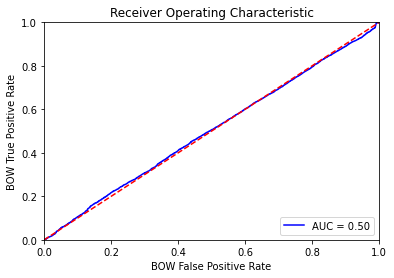

In [494]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bow, tpr_bow)
plt.plot(fpr_bow, tpr_bow, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BOW True Positive Rate')
plt.xlabel('BOW False Positive Rate')
plt.show()

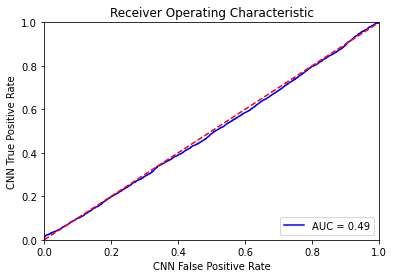

In [495]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('CNN True Positive Rate')
plt.xlabel('CNN False Positive Rate')
plt.show()

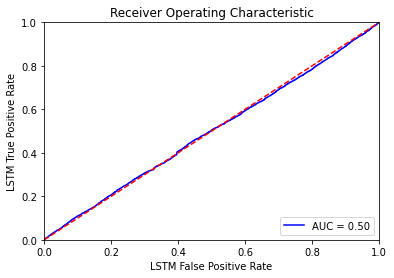

In [497]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('LSTM True Positive Rate')
plt.xlabel('LSTM False Positive Rate')
plt.show()

The results look like random guess, so we will not calculate ordering metrics for these models